In [1]:
# imports
import cv2
import os
import numpy as np
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.transforms.functional  import InterpolationMode
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import statistics
from statistics import mean
import PIL
import matplotlib.pyplot as plt
import numpy as np





# fill in details:

Student ID: 212229512

Student first name: Nava

Student last name:Naane

**Project Scope**:
Build a CNN classifier from scratch, on your own data that works on your live stream.

1. Acquire dataset (Train and Validation):

   Grab frames from your camera for 3 classes (your own selection).
   The amount of data to collect, is decided by you to reach good live performance.
2. Define pytorch dataset and data loader:
Define train and validation datasets and dataloader using **dset.ImageFolder(...)** with proper transforms. Also plot a few training and validation batches.

3. Define your CNN network (**must use pytorch, and build your own network**)
4. Train your network:

   Train the network, print training accuracy and loss per epoch, and also for the validation. **Save the best model to disk, and download it**.
   Plot a few validation batches, with their labels and their predictions.

5. Live model inference:
Connect to your laptop camera, grab frame by frame, and plot on the image the classification of the frame. If you did everything right, your model should work quite well.

**items to submit for this assignment**:
1. Students that will demonstrate their project on live stream (and it really works..) until the deadline, will not have to submit any item
2. Otherwise submit the following:
   - This notebook, filled with all the **#place your code here** areas
   - your model saved for inference
   - 3 batches on the validation, with labels and predictions
   - 3 Minutes video file, demonstrating the student performing the 3 classes, with the model classification per frame plotted in the video


#Data set collection#

In [ ]:
# Create Directories
dataset_dir = './dataset/'
num_classes = 3

# Place your code here (1): describe your classes
text_for_classes = ['Wolf','Little Red Riding Hood','Nothing']

num_of_images_to_save = 50

os.mkdir(dataset_dir)
os.mkdir(dataset_dir + 'train')
os.mkdir(dataset_dir + 'test')

# Create directories
[os.mkdir(dataset_dir + 'train/' + str(i)) for i in range(num_classes)]
[os.mkdir(dataset_dir + 'test/' + str(i)) for i in range(num_classes)]


[None, None, None]

In [2]:
# Place your code here (2): define your own video width and height
width = 160
height = 120

# functions for capturing webcam
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame(width, height) {
      if (!shutdown) {
         window.requestAnimationFrame(function() {
            onAnimationFrame(width, height);
    });
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, width, height);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom(width, height) {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = width; //video.videoWidth;
      captureCanvas.height = height; //video.videoHeight;
      window.requestAnimationFrame(function() {
      onAnimationFrame(width, height);
    });
      return stream;
    }

 async function stop_sream() {
        shutdown = true;
        removeDom();

        return '';
 }

    async function stream_frame(label, imgData, width, height) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom(width, height);

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox, width, videoHeight):
  data = eval_js('stream_frame("{}", "{}", "{}", "{}")'.format(label, bbox, width, height))
  return data

def video_stream_stop():
  eval_js('stop_sream("{}")')


In [ ]:
from datetime import datetime
def grab_dataset(save_path):
    for i in range(num_classes):
      input('Press Enter to capture class ' + text_for_classes[i] + '...')
      # start streaming video from webcam
      frame_num = 0
      saved_frames = 0
      video_stream()
      # label for video
      label_html = 'Capturing...'
      # initialze bounding box to empty
      bbox = ''
      count = 0
      file_names = []
      frames = []
      while True:
          frame_num = frame_num + 1
          js_reply = video_frame(label_html, bbox, width, height)
          if not js_reply:
              break

          # convert JS response to OpenCV Image
          frame = js_to_image(js_reply["img"])

          # Save Frames
          label_html = 'Saving...' + str(saved_frames)
          file_name = save_path + str(i) + '/' + datetime.now().strftime("%m_%d_%Y_%H_%M_%S_") + str(frame_num) + '.jpg'
          file_names.append(file_name)
          frames.append(frame)
            #cv2.imwrite(file_name, frame)
          saved_frames = saved_frames + 1

          if saved_frames == num_of_images_to_save:
            video_stream_stop()
            print ('saving to disk...')
            for i,f in enumerate(file_names):
              cv2.imwrite(f, frames[i])
            break



In [ ]:
# grab your dataset --> this should be an ongoing process, till you get good performance

grab_dataset(dataset_dir + '/train/')
grab_dataset(dataset_dir + '/test/')

Press Enter to capture class Wolf...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Little Red Riding Hood...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Nothing...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Wolf...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Little Red Riding Hood...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Nothing...


<IPython.core.display.Javascript object>

saving to disk...


In [ ]:
# download dataset (so can merge with the dataset you already collected, and later upload it to colab)
from google.colab import files
!zip -r ./ds.zip ./dataset/
files.download('./ds.zip')

updating: dataset/ (stored 0%)
updating: dataset/test/ (stored 0%)
updating: dataset/test/1/ (stored 0%)
updating: dataset/test/1/06_02_2024_16_46_10_23.jpg (deflated 5%)
updating: dataset/test/1/06_02_2024_16_46_11_25.jpg (deflated 5%)
updating: dataset/test/1/06_02_2024_16_46_19_43.jpg (deflated 6%)
updating: dataset/test/1/06_02_2024_16_46_17_38.jpg (deflated 5%)
updating: dataset/test/1/06_02_2024_16_46_06_15.jpg (deflated 5%)
updating: dataset/test/1/06_02_2024_16_46_03_9.jpg (deflated 6%)
updating: dataset/test/1/06_02_2024_16_46_03_8.jpg (deflated 6%)
updating: dataset/test/1/06_02_2024_16_46_16_37.jpg (deflated 5%)
updating: dataset/test/1/06_02_2024_16_46_08_20.jpg (deflated 5%)
updating: dataset/test/1/06_02_2024_16_46_14_32.jpg (deflated 5%)
updating: dataset/test/1/06_02_2024_16_46_02_6.jpg (deflated 6%)
updating: dataset/test/1/06_02_2024_16_46_17_40.jpg (deflated 5%)
updating: dataset/test/1/06_02_2024_16_46_20_46.jpg (deflated 5%)
updating: dataset/test/1/06_02_2024_16_4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# dataset upload (Now you have a dataset and need to upload it for training)

# download dataset
from google.colab import files

files.upload()

Saving ds.zip to ds.zip


In [4]:
#extract your dataset zip file
!unzip /content/ds.zip

Archive:  /content/ds.zip
   creating: ds/dataset/
   creating: ds/dataset/test/
   creating: ds/dataset/train/
   creating: ds/dataset/test/0/
   creating: ds/dataset/test/1/
   creating: ds/dataset/test/2/
   creating: ds/dataset/train/0/
   creating: ds/dataset/train/1/
   creating: ds/dataset/train/2/
  inflating: ds/dataset/test/0/05_29_2024_10_00_49_2.jpg  
  inflating: ds/dataset/test/0/05_29_2024_10_00_49_3.jpg  
  inflating: ds/dataset/test/0/05_29_2024_10_00_50_4.jpg  
  inflating: ds/dataset/test/0/05_29_2024_10_00_52_7.jpg  
  inflating: ds/dataset/test/0/05_29_2024_10_00_53_8.jpg  
  inflating: ds/dataset/test/0/05_29_2024_10_00_53_9.jpg  
  inflating: ds/dataset/test/0/05_29_2024_10_00_54_10.jpg  
  inflating: ds/dataset/test/0/05_29_2024_10_00_55_13.jpg  
  inflating: ds/dataset/test/0/05_29_2024_10_00_56_14.jpg  
  inflating: ds/dataset/test/0/05_29_2024_10_00_56_15.jpg  
  inflating: ds/dataset/test/0/05_29_2024_10_00_57_17.jpg  
  inflating: ds/dataset/test/0/05_29_20

#Dataset definition#

In [30]:
# Define the paths to your train and test data directories
test_dir = '/content/ds/dataset/test'
train_dir = '/content/ds/dataset/train'
dataset_dir = '/content/ds/dataset'

#Compute the mean and std:

In [ ]:
# Batch size
BATCH_SIZE = 32

# Define the transformation without resizing
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Load the dataset without resizing
dataset_train = ImageFolder(train_dir, transform=transform)
dataset_val = ImageFolder(test_dir, transform=transform)

# Define a data loader for the dataset
data_loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
data_loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

# Initialize variables to store sum of pixel values and sum of squared pixel values
sum_pixel_values_train = torch.zeros(3)  # For RGB images
sum_squared_pixel_values_train = torch.zeros(3)

sum_pixel_values_val = torch.zeros(3)  # For RGB images
sum_squared_pixel_values_val = torch.zeros(3)

num_samples_train = 0
num_samples_val = 0

# Compute the sum of pixel values and sum of squared pixel values for training set
for images, _ in data_loader_train:
    num_samples_train += images.size(0)
    sum_pixel_values_train += torch.sum(images, dim=[0, 2, 3])
    sum_squared_pixel_values_train += torch.sum(images ** 2, dim=[0, 2, 3])

# Compute the sum of pixel values and sum of squared pixel values for validation set
for images, _ in data_loader_val:
    num_samples_val += images.size(0)
    sum_pixel_values_val += torch.sum(images, dim=[0, 2, 3])
    sum_squared_pixel_values_val += torch.sum(images ** 2, dim=[0, 2, 3])

# Compute the mean and standard deviation
mean_train = sum_pixel_values_train / (num_samples_train * images.size(2) * images.size(3))
std_train = torch.sqrt((sum_squared_pixel_values_train / (num_samples_train * images.size(2) * images.size(3))) - (mean_train ** 2))

mean_val = sum_pixel_values_val / (num_samples_val * images.size(2) * images.size(3))
std_val = torch.sqrt((sum_squared_pixel_values_val / (num_samples_val * images.size(2) * images.size(3))) - (mean_val ** 2))

print("Mean train:", mean_train)
print("Standard Deviation train:", std_train)

print("Mean validation:", mean_val)
print("Standard Deviation validation:", std_val)

Mean train: tensor([0.6448, 0.6032, 0.6056])
Standard Deviation train: tensor([0.2504, 0.2871, 0.2893])
Mean validation: tensor([0.6453, 0.6054, 0.6065])
Standard Deviation validation: tensor([0.2476, 0.2832, 0.2858])


In [ ]:
# # Place your code here (3):
# # define:
# # Batch size
# #BATCH_SIZE = 32

# # Train and validation transforms using transforms.Compose
# data_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.6467, 0.6067, 0.6065), (0.2084, 0.2437, 0.2560))
#     ])

# # Train and validation datasets using dset.ImageFolder
# train_dataset = ImageFolder(train_dir, transform=transform)
# val_dataset = ImageFolder(test_dir , transform=transform)

# # Train and validation dataloaders using torch.utils.data.DataLoader
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE, shuffle=True)

# # print the length of your train and validation sets
# print(len(train_dataset))
# print(len(val_dataset))

# # plot a few training batches with their labels (make sure you can recognize the classes after the transforms , example code below)

# # plot a few validation batches with their labels

# # print the shape of a single batch of images, and their min, max, and average pixel value
# # אחרי הנרמול צריך לעשות נורמליזציה גם לטסט לפי הסטיית תקן והממוצע
# # לבדוק- אולי אפשר בלי הנרמול כלל
# #dropout
# #rgb to bgr


450
450


In [31]:
# Place your code here (3):
# define:
# Batch size
BATCH_SIZE = 32

# Train and validation transforms using transforms.Compose
transform = transforms.Compose([
    transforms.ToTensor()])

# Train and validation datasets using dset.ImageFolder
train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(test_dir , transform=transform)

# Train and validation dataloaders using torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE, shuffle=True)

# print the length of your train and validation sets
print(len(train_dataset))
print(len(val_dataset))

# plot a few training batches with their labels (make sure you can recognize the classes after the transforms , example code below)

# plot a few validation batches with their labels

# print the shape of a single batch of images, and their min, max, and average pixel value
# אחרי הנרמול צריך לעשות נורמליזציה גם לטסט לפי הסטיית תקן והממוצע
# לבדוק- אולי אפשר בלי הנרמול כלל
#dropout
#rgb to bgr


1260
540


In [ ]:
# ## functions to show an image
# def imshow(img):
#     #img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

# ## get some random training images
# dataiter = iter(train_loader)
# images, labels = next(dataiter)

# ## show images
# imshow(torchvision.utils.make_grid(images))
# labels

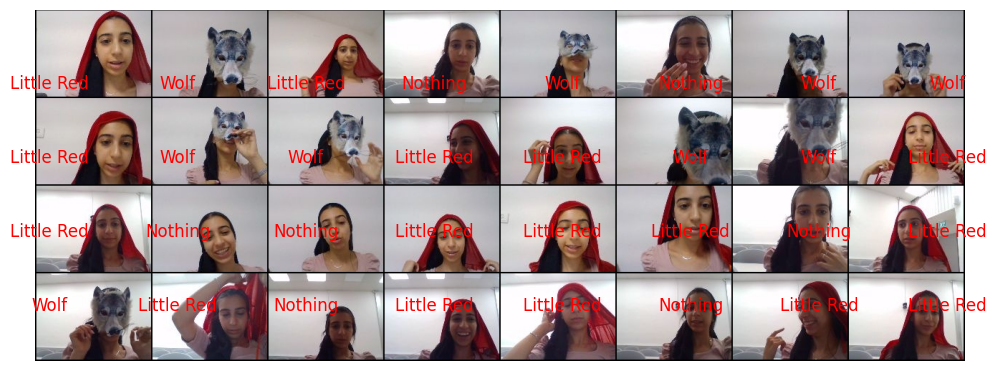

In [ ]:
# plot a few training batches with their labels

short_text_for_classes = ['Wolf','Little Red','Nothing']
# Define the imshow function with labels
def imshow(img, labels, class_names):
    # Convert PyTorch tensor to NumPy array
    npimg = img.numpy()
    # Transpose the array to match the image format (HWC)
    npimg = np.transpose(npimg, (1, 2, 0))

    # Display the combined image grid
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(npimg)

    # Get the number of images in the grid (assuming square rootable grid shape)
    num_images = labels.size(0)
    grid_size = int(np.sqrt(num_images))
    num_of_cols = 8

    # Calculate the width and height of each image in the grid
    img_width = npimg.shape[1] // grid_size -80
    img_height = npimg.shape[0] // grid_size +5

    # Iterate over each label and write it above the corresponding image
    for i in range(num_images):
        col = i % num_of_cols
        row = i // num_of_cols
        x = col * img_width
        y = row * img_height
        class_name = class_names[labels[i].item()]
        ax.text(x + img_width // 2 -70, y + 110, class_name, color='red', fontsize=12, ha='center')  # Adjust y + 110 for closer labels

    # Hide the axes
    ax.axis('off')
    # Show the plot
    plt.show()

# Get some random training images and labels
dataiter = iter(train_loader)
images_train, labels = next(dataiter)

# Show images with labels
imshow(torchvision.utils.make_grid(images_train), labels, short_text_for_classes)

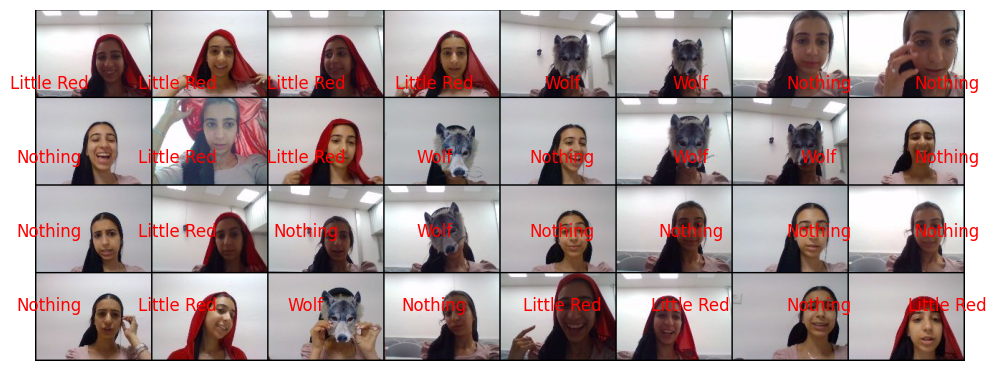

In [ ]:
# Get some random validation images and labels
dataiter2 = iter(val_loader)
images_val, labels = next(dataiter2)

# Show images with labels
imshow(torchvision.utils.make_grid(images_val), labels, short_text_for_classes)

In [ ]:
# print the shape of a single batch of images, and their min, max, and average pixel value
# Print shape of a single batch of images
print("Shape of a single batch of images train:", images_train.shape)

# Calculate and print min, max, and average pixel values
min_pixel_value_train = images_train.min().item()
max_pixel_value_train = images_train.max().item()
avg_pixel_value_train = images_train.mean().item()

print("Min pixel value:", min_pixel_value_train)
print("Max pixel value:", max_pixel_value_train)
print("Average pixel value:", avg_pixel_value_train)

Shape of a single batch of images train: torch.Size([32, 3, 120, 160])
Min pixel value: 0.0
Max pixel value: 1.0
Average pixel value: 0.6089833974838257


In [ ]:
# print the shape of a single batch of images, and their min, max, and average pixel value
# Print shape of a single batch of images
print("Shape of a single batch of images validation:", images_val.shape)

# Calculate and print min, max, and average pixel values
min_pixel_value_validation = images_val.min().item()
max_pixel_value_validation = images_val.max().item()
avg_pixel_value_validation = images_val.mean().item()

print("Min pixel value:", min_pixel_value_validation)
print("Max pixel value:", max_pixel_value_validation)
print("Average pixel value:", avg_pixel_value_validation)

Shape of a single batch of images validation: torch.Size([32, 3, 120, 160])
Min pixel value: 0.0
Max pixel value: 1.0
Average pixel value: 0.6253937482833862


#Training#

In [5]:
# Place your code here (4): define your CNN

class liveClassifier(nn.Module):
    def __init__(self, num_channels=3, num_classes=3):
        super(liveClassifier, self).__init__()
        # 3x120x160 ==> 32x118x158
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=0)
        # 32x118x158 ==> 32x59x79
        self.pool1 = nn.MaxPool2d(2)
        # 32x59x79 ==> 64x57x77
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        # 64x57x77 ==> 64x28x38
        self.pool2 = nn.MaxPool2d(2)
        # 64x28x38 ==> 64x26x36
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)

        # 64x26x36 ==> 64
        self.fc1 = nn.Linear(26*36*64, 64, bias=True)
        # 64 ==> num_classes (3 classes)
        self.fc2 = nn.Linear(64, num_classes)


    def forward(self, X):
      # Place your code here (4.2): define forward pass
      x = F.relu(self.conv1(X))
      x = self.pool1(x)
      x = F.relu(self.conv2(x))
      x = self.pool2(x)
      x = F.relu(self.conv3(x))
      x = x.view(-1, 26*36*64)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x




In [ ]:
# Create an instance of your model, and print its summary
num_channels = 3
num_classes = 3

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# שמתי בהערה כי הגדרתי מודל למעלה במקומו שמתי את השורה מתחת
#model = liveClassifier().to(device)
model = liveClassifier(num_channels=num_channels, num_classes=num_classes).to(device)

# Place your code here (5): print summary using summary(model,(aa, bb, bb ))
summary(model, (num_channels, 120, 160))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 118, 158]             896
         MaxPool2d-2           [-1, 32, 59, 79]               0
            Conv2d-3           [-1, 64, 57, 77]          18,496
         MaxPool2d-4           [-1, 64, 28, 38]               0
            Conv2d-5           [-1, 64, 26, 36]          36,928
            Linear-6                   [-1, 64]       3,833,920
            Linear-7                    [-1, 3]             195
Total params: 3,890,435
Trainable params: 3,890,435
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.22
Forward/backward pass size (MB): 8.81
Params size (MB): 14.84
Estimated Total Size (MB): 23.87
----------------------------------------------------------------


In [ ]:
# Place your code here (6): Define your loss criterion, and optimizer (e.g criterion = nn.CrossEntropyLoss(), optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum = 0.9)

cuda = torch.device('cuda')
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#Place your code here (7.1): Train (don't forget to call model.train())
def train(model, loss_fn, optimizer):
    model.train()

    train_batch_losses = []

    for batch, labels in train_loader:
        batch = batch.to(cuda)
        labels = labels.to(cuda)

        optimizer.zero_grad()
        y_pred = model(batch)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()

        train_batch_losses.append(float(loss))

        mean_loss = statistics.mean(train_batch_losses)

    return mean_loss

#Place your code here (7.2): Evaluate (don't forget to call model.eval())
def validate(model, loss_fn, optimizer):
    model.eval()

    predictions = []

    with torch.no_grad():
        validation_batch_losses = []

        for batch, labels in val_loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)

            labels_pred = model(batch)
            loss = loss_fn(labels_pred, labels)

            validation_batch_losses.append(float(loss))

            mean_loss = statistics.mean(validation_batch_losses)

    return mean_loss

def accuracy(model, loader):
    correct = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for batch, labels in loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)

            labels_pred = model(batch)

            _, predicted = torch.max(labels_pred.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (100 * correct / total)

In [ ]:

# Place your code here (7): train loop

# num_epochs = 30

# for epoch in range(num_epochs):

  #Place your code here (7.1): Train (don't forget to call model.train())

  #Place your code here (7.2): Evaluate (don't forget to call model.eval())

  #Place your code here (7.3): Print Train loss and accuracy, print Eval loss and accuracy

  #Place your code here (7.4): If model has improved, save it to disk using torch.save(model.state_dict(), dataset_dir + 'savedmodel')


#Place your code here (7.5): print your best model performance (evaluation loss and accuracy)
#Place your code here (7.6): plot loss and accuracy curves (Train + evaluation)





In [ ]:
#Place your code here (7.3): Print Train loss and accuracy, print Eval loss and accuracy
epochs = 29

train_losses = []
valid_losses = []

train_accuracies = []
valid_accuracies = []

valid_loss = float('inf')
valid_accuracy = 0.0

for epoch in range(1, epochs +  1):

    print('Epoch: ', epoch)

    train_loss = train(model, loss_fn, optimizer)
    train_accuracy = accuracy(model, train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print('Training loss:', train_loss)
    print('Training accuracy: {}%'.format(train_accuracy))

    valid_loss = validate(model, loss_fn, optimizer)
    valid_accuracy = accuracy(model, val_loader)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print('Validation loss:', valid_loss)
    print('Validation accuracy: {}%'.format(valid_accuracy))


Epoch:  1
Training loss: 1.0994308084249496
Training accuracy: 37.38095238095238%
Validation loss: 1.0963111134136425
Validation accuracy: 39.074074074074076%
Epoch:  2
Training loss: 1.0955799788236618
Training accuracy: 60.63492063492063%
Validation loss: 1.0927016244215124
Validation accuracy: 59.074074074074076%
Epoch:  3
Training loss: 1.0907816588878632
Training accuracy: 66.98412698412699%
Validation loss: 1.0864067358129166
Validation accuracy: 65.37037037037037%
Epoch:  4
Training loss: 1.0805476158857346
Training accuracy: 49.76190476190476%
Validation loss: 1.0728001173804789
Validation accuracy: 49.629629629629626%
Epoch:  5
Training loss: 1.0550299793481828
Training accuracy: 64.52380952380952%
Validation loss: 1.033729174557854
Validation accuracy: 62.592592592592595%
Epoch:  6
Training loss: 0.9762620523571968
Training accuracy: 55.55555555555556%
Validation loss: 0.9283457223106834
Validation accuracy: 53.51851851851852%
Epoch:  7
Training loss: 0.8276828065514564
Train

In [ ]:
# Place your code here (7.5): Print your best model performance (evaluation loss and accuracy)
print('Best Validation Loss:', valid_loss)
print('Best Validation Accuracy: {}%'.format(valid_accuracy))

Best Validation Loss: 0.081772071254604
Best Validation Accuracy: 97.03703703703704%


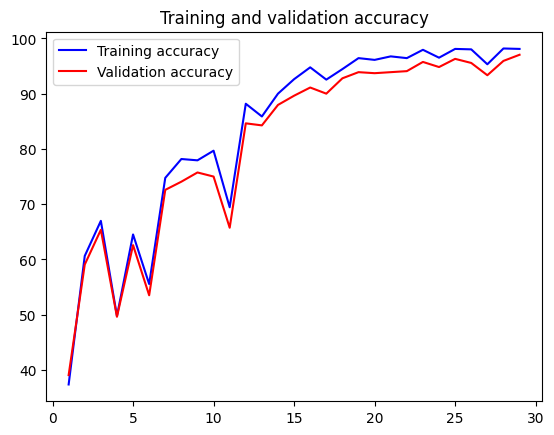

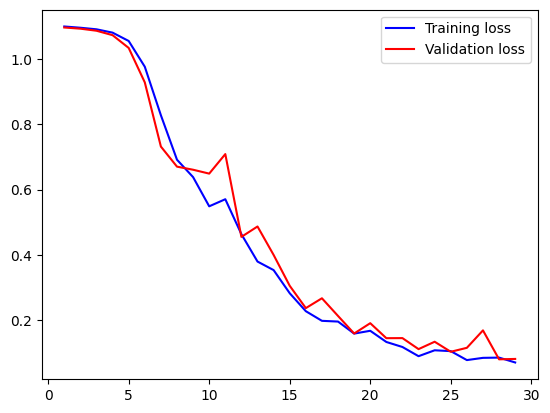

In [ ]:
#Place your code here (7.6): plot loss and accuracy curves (Train + evaluation)
epochs = range(1, 29 + 1)

plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, valid_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.legend()

plt.show()

In [ ]:
#Place your code here (7.4): If model has improved, save it to disk using torch.save(model.state_dict(), dataset_dir + 'savedmodel')
torch.save(model.state_dict(), '/content/ds/dataset/savedmodel')
# download model
files.download('/content/ds/dataset/savedmodel')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# upload model
files.upload()

Saving savedmodel to savedmodel


In [7]:
device = torch.device("cpu")

In [8]:
# load model
model = liveClassifier()
model.load_state_dict(torch.load('/content/savedmodel',map_location=torch.device('cpu')))
model.to(device)
model.eval()

liveClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=59904, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

## Inference

In [27]:
def imshow_predict(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

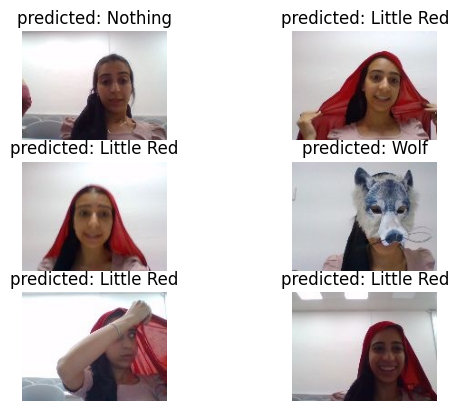

In [33]:
text_for_classes = ['Wolf','Little Red','Nothing']
# Place your code here (8): Plot few batches with their labels and predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {text_for_classes[preds[j]]}')
                imshow_predict(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)


In [39]:
# Place your code here (9): Run live inference, plot classification on the video using bbox_array = cv2.putText(img=bbox_array, text=pred_class_name, org=(x, y), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.6, color=(200, 200, 200, 255),thickness=1)
# Also save frames with classification plotted on it to video file (download it for submition)
from IPython.display import Javascript

# Display a Javascript code snippet to request camera access
display(Javascript("""
  async function requestCameraAccess() {
    const stream = await navigator.mediaDevices.getUserMedia({video: true});
    google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
  }

  requestCameraAccess();
"""))

<IPython.core.display.Javascript object>

In [9]:
import time
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from base64 import b64decode, b64encode
from IPython.display import display, Javascript
from google.colab.output import eval_js
import PIL
import io
from torchvision import transforms

# Assuming you have already defined the model and loaded its weights

# Define the image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Define class names (adjust based on your dataset)
class_names = ['Wolf', 'Little Red Riding Hood', 'Nothing']

# Constants
capture_width = 320  # Reduced width for better performance
capture_height = 240  # Reduced height for better performance
model_input_width = 160  # Model input width
model_input_height = 120  # Model input height

# Function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# Function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

# JavaScript to capture webcam
def video_stream():
    js = Javascript(f'''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;

        var pendingResolve = null;
        var shutdown = false;

        function removeDom() {{
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();
            video = null;
            div = null;
            stream = null;
            imgElement = null;
            captureCanvas = null;
            labelElement = null;
        }}

        function onAnimationFrame(width, height) {{
            if (!shutdown) {{
                window.requestAnimationFrame(function() {{
                    onAnimationFrame(width, height);
                }});
            }}
            if (pendingResolve) {{
                var result = "";
                if (!shutdown) {{
                    captureCanvas.getContext('2d').drawImage(video, 0, 0, width, height);
                    result = captureCanvas.toDataURL('image/jpeg', 0.5);  // Set JPEG quality to 0.5
                }}
                var lp = pendingResolve;
                pendingResolve = null;
                lp(result);
            }}
        }}

        async function createDom(width, height) {{
            if (div !== null) {{
                return stream;
            }}

            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '600px';
            document.body.appendChild(div);

            const modelOut = document.createElement('div');
            modelOut.innerHTML = "Status:";
            labelElement = document.createElement('span');
            labelElement.innerText = 'No data';
            labelElement.style.fontWeight = 'bold';
            modelOut.appendChild(labelElement);
            div.appendChild(modelOut);

            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth - 6;
            video.setAttribute('playsinline', '');
            video.onclick = () => {{ shutdown = true; }};
            stream = await navigator.mediaDevices.getUserMedia(
                {{video: {{ facingMode: "environment", width: {capture_width}, height: {capture_height} }} }});
            div.appendChild(video);

            imgElement = document.createElement('img');
            imgElement.style.position = 'absolute';
            imgElement.style.zIndex = 1;
            imgElement.onclick = () => {{ shutdown = true; }};
            div.appendChild(imgElement);

            const instruction = document.createElement('div');
            instruction.innerHTML =
                '' +
                'When finished, click here or on the video to stop this demo';
            div.appendChild(instruction);
            instruction.onclick = () => {{ shutdown = true; }};

            video.srcObject = stream;
            await video.play();

            captureCanvas = document.createElement('canvas');
            captureCanvas.width = width;
            captureCanvas.height = height;
            window.requestAnimationFrame(function() {{
                onAnimationFrame(width, height);
            }});
            return stream;
        }}

        async function stop_stream() {{
            shutdown = true;
            removeDom();
            return '';
        }}

        async function stream_frame(label, imgData, width, height) {{
            if (shutdown) {{
                removeDom();
                shutdown = false;
                return '';
            }}

            var preCreate = Date.now();
            stream = await createDom(width, height);

            var preShow = Date.now();
            if (label != "") {{
                labelElement.innerHTML = label;
            }}

            if (imgData != "") {{
                var videoRect = video.getClientRects()[0];
                imgElement.style.top = videoRect.top + "px";
                imgElement.style.left = videoRect.left + "px";
                imgElement.style.width = videoRect.width + "px";
                imgElement.style.height = videoRect.height + "px";
                imgElement.src = imgData;
            }}

            var preCapture = Date.now();
            var result = await new Promise(function(resolve, reject) {{
                pendingResolve = resolve;
            }});
            shutdown = false;

            return {{'create': preShow - preCreate,
                    'show': preCapture - preShow,
                    'capture': Date.now() - preCapture,
                    'img': result}};
        }}
    ''')

    display(js)

def video_frame(label, bbox, width, height):
    data = eval_js('stream_frame("{}", "{}", "{}", "{}")'.format(label, bbox, width, height))
    return data

def video_stream_stop():
    eval_js('stop_stream("{}")')

# Start the video stream
video_stream()

frame_counter = 0

# Capture and classify video frames
while True:
    start_time = time.time()
    js_reply = video_frame('', '', capture_width, capture_height)
    if not js_reply:
        break

    frame_counter += 1

    # Skip every other frame to reduce processing load
    if frame_counter % 2 != 0:
        continue

    # Convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Preprocess the frame
    img = cv2.resize(frame_rgb, (model_input_width, model_input_height))  # Resize to your model input size
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        outputs = model(img)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        pred_class_name = class_names[predicted.item()]
        pred_confidence = confidence.item()

    # Plot classification result on the frame
    x, y = 10, 10  # Position to display the text
    cv2.putText(frame, f"{pred_class_name}: {pred_confidence:.2f}", (x, y),
                cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255), 1)

    # Convert frame to bytes
    bbox_array = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Update the video frame with the bounding box
    js_reply = video_frame(f"{pred_class_name}: {pred_confidence:.2f}", bbox_bytes, capture_width, capture_height)
    if not js_reply:
        break

    # Calculate and print frame processing time for debugging
    end_time = time.time()

# Stop the video stream
video_stream_stop()



<IPython.core.display.Javascript object>

MessageError: TypeError: Cannot read properties of null (reading 'getVideoTracks')

**I hope you had fun (-:**

Good luck!

Lahav